## Imports

In [1]:
import scan_transform
import cv2 as cv2
import matplotlib.pyplot as plt
import numpy as np

## Image Transformation

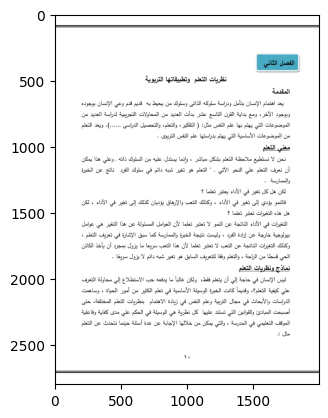

In [3]:
image=scan_transform.preprocess_image('page_15.png')
#Show image
plt.imshow(image)

## Yolo image segmentation Model

###### This model has 2 clases [ images , diagrams].
###### It prepares the image to be an input for the ocr model by masking off any obstacles during the ocr process.
###### Detected classes will be an input for an arabic LLM.

In [4]:
import tensorflow as tf
from ultralytics import YOLO

tf_savedmodel_model = YOLO("best.pt",task='detect')


/Users/maryamsaad/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Starting image processing...

0: 512x384 1 image, 19.0ms
Speed: 1.4ms preprocess, 19.0ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 384)


<Figure size 640x480 with 0 Axes>

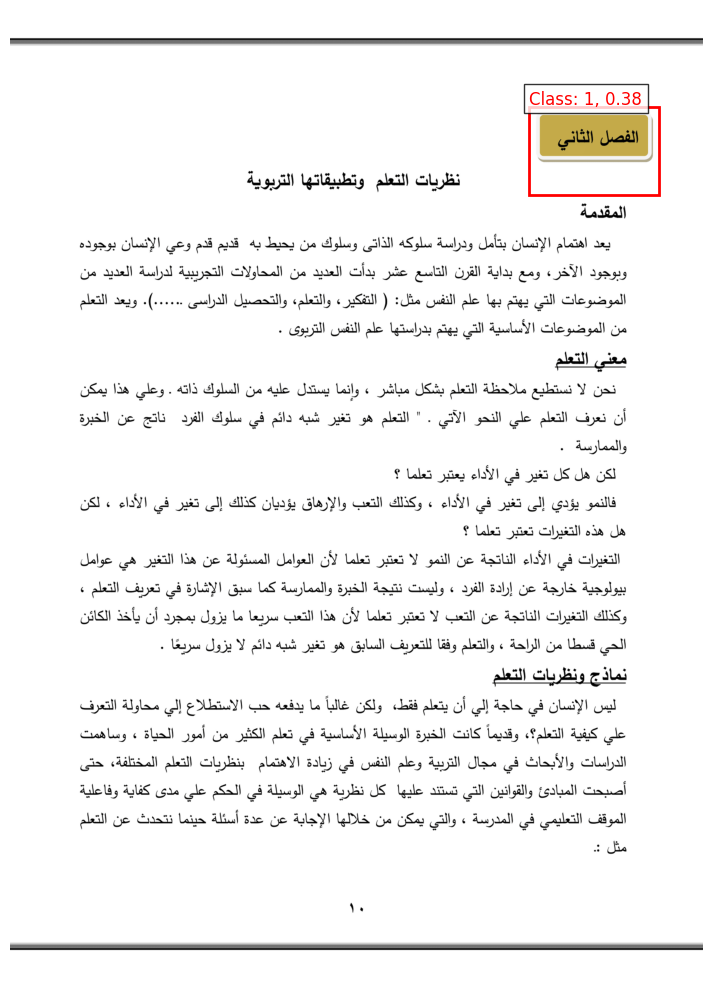

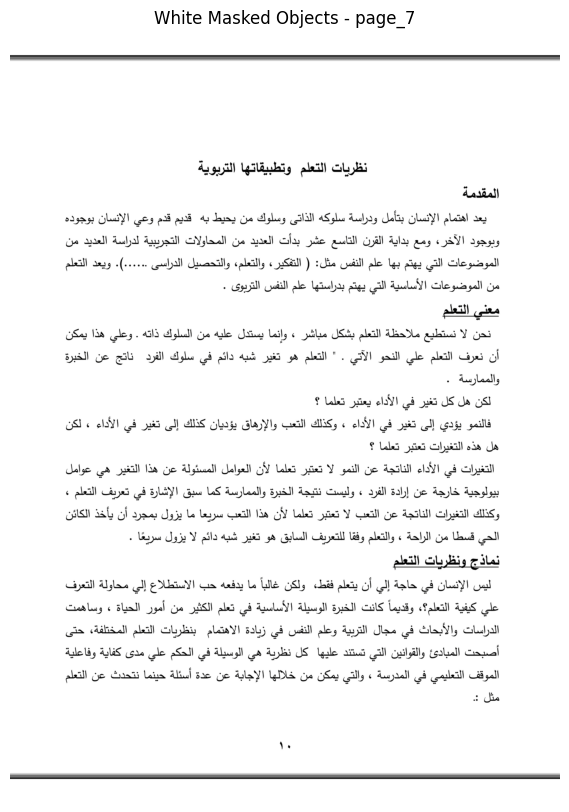

Processing complete.
Data for image page_7:
Number of boxes detected: 1


In [5]:
def process_images(image, image_id=None):
    print("Starting image processing...")

    # Create a copy of the original image to apply the mask
    processed_image = image.copy()

    # Create a blank mask with same dimensions as image
    mask = np.zeros(image.shape, dtype=np.uint8)
    # Fill mask with white
    mask[:] = (255, 255, 255)  # White color for all channels

    # Dictionary to store all image data
    images_dict = {}

    # Predict with lower confidence threshold
    results = tf_savedmodel_model.predict(image, verbose=True)
    result = results[0]

    # Convert BGR to RGB for matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Create figure with larger size and clear any existing plots
    plt.clf()
    plt.figure(figsize=(15, 10))

    # Display the image
    plt.imshow(image_rgb)

    # Create a binary mask for detected objects
    binary_mask = np.zeros(image.shape[:2], dtype=np.uint8)

    # Store current image data
    current_image_data = {
        "boxes": [],
        "binary_mask": None,
        "masked_image": None
    }

    if len(result.boxes) > 0:
        boxes = result.boxes.xyxy.cpu().numpy()
        classes = result.boxes.cls.cpu().numpy()
        confidences = result.boxes.conf.cpu().numpy()

        for i, (box, cls, conf) in enumerate(zip(boxes, classes, confidences)):
            x1, y1, x2, y2 = box.astype(int)

            # Add to binary mask - fill with white (255)
            cv2.rectangle(binary_mask, (x1, y1), (x2, y2), 255, -1)  # -1 means filled

            # Store box info
            box_info = {
                "coordinates": [x1, y1, x2, y2],
                "class": int(cls),
                "confidence": float(conf)
            }
            current_image_data["boxes"].append(box_info)

            # Draw rectangle with thicker lines
            rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                               fill=False, color='red', linewidth=2)
            plt.gca().add_patch(rect)

            # Add label with larger font
            label = f"Class: {int(cls)}, {conf:.2f}"
            plt.text(x1, y1-10, label,
                    color='red',
                    fontsize=12,
                    bbox=dict(facecolor='white', alpha=0.8))

    # Create the final masked image:
    # 1. Where binary_mask is 255 (objects), use the white mask
    # 2. Where binary_mask is 0 (background), use the original image
    for c in range(0, 3):  # For each color channel
        processed_image[:, :, c] = np.where(binary_mask == 255,
                                         mask[:, :, c],
                                         processed_image[:, :, c])

    # Store masks and processed image in the data
    current_image_data["binary_mask"] = binary_mask
    current_image_data["masked_image"] = processed_image

    # Store image data in dictionary if image_id is provided
    if image_id is not None:
        images_dict[image_id] = current_image_data

    plt.axis('off')
    plt.tight_layout()
    plt.draw()
    plt.pause(0.1)
    plt.show()

    # Show the masked image
    plt.figure(figsize=(15, 10))
    masked_rgb = cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB)
    plt.imshow(masked_rgb)
    plt.title(f"White Masked Objects - {image_id}")
    plt.axis('off')
    plt.show()

    print("Processing complete.")

    # Return the images dictionary
    return processed_image,images_dict

# Example usage
image_id = "page_7"  # Using the image name as ID
processed_image,images_dict = process_images(image, image_id)


# Print the dictionary structure
print(f"Data for image {image_id}:")
print(f"Number of boxes detected: {len(images_dict[image_id]['boxes'])}")

## OCR Model

In [6]:
!pip3 install transformers qwen_vl_utils accelerate>=0.26.0 PEFT -U

zsh:1: 0.26.0 not found


In [7]:
!pip3 install -U bitsandbytes

Defaulting to user installation because normal site-packages is not writeable


In [8]:
from PIL import Image
from transformers import Qwen2VLForConditionalGeneration, AutoProcessor
import torch
import os
from qwen_vl_utils import process_vision_info

model_name = "NAMAA-Space/Qari-OCR-0.2.2.1-VL-2B-Instruct"
model = Qwen2VLForConditionalGeneration.from_pretrained(
                model_name,
                device_map="auto",
                torch_dtype=torch.bfloat16,
                load_in_8bit=True,
                trust_remote_code=True

            )
processor = AutoProcessor.from_pretrained(model_name)
max_tokens = 2000

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


ImportError: Using `bitsandbytes` 8-bit quantization requires the latest version of bitsandbytes: `pip install -U bitsandbytes`

In [ ]:
image_path = os.path.join( "/content/", f"page_{7}.png")
image = Image.open(image_path)
image = image.resize((image.width // 2, image.height // 2))
prompt = "Below is the image of one page of a document, as well as some raw textual content that was previously extracted for it. Just return the plain text representation of this document as if you were reading it naturally. Do not hallucinate."
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image},
            {"type": "text", "text": prompt},
        ],
    }
]
text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")
generated_ids = model.generate(**inputs, max_new_tokens=max_tokens)
generated_ids_trimmed = [
    out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)[0]
print(output_text)

In [ ]:
#multi image and json
# # Directory containing PNG and JSON files
# directory = "/content/"
# output_texts = {}

# # Reduced max_tokens
# max_tokens = 1000  # Reduced from 2000

# for i in range(6, 17):  # For page_6 to page_16
#     image_path = os.path.join(directory, f"page_{i}.png")

#     # Load and resize image
#     image = Image.open(image_path)
#     image = image.resize((image.width // 2, image.height // 2))  # Reduce resolution by half

#     prompt = "Below is the image of one page of a document, as well as some raw textual content that was previously extracted for it. Just return the plain text representation of this document as if you were reading it naturally. Do not hallucinate."

#     messages = [
#         {
#             "role": "user",
#             "content": [
#                 {"type": "image", "image": image},
#                 {"type": "text", "text": prompt},
#             ],
#         }
#     ]

#     # Process the image with your model
#     text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
#     image_inputs, video_inputs = process_vision_info(messages)
#     inputs = processor(
#         text=[text],
#         images=image_inputs,
#         videos=video_inputs,
#         padding=True,
#         return_tensors="pt",
#     )
#     inputs = inputs.to("cuda")
#     generated_ids = model.generate(**inputs, max_new_tokens=max_tokens)
#     generated_ids_trimmed = [
#         out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
#     ]
#     output_text = processor.batch_decode(
#         generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
#     )[0]
#     print(f"page {i} is processed")
#     # Store the OCR output
#     output_texts[f"page_{i}"] = output_text

In [ ]:
output_text

### PostProcessing

In [ ]:
from transformers import AutoModelForCausalLM, BitsAndBytesConfig
model_id = "core42/jais-13b-chat"
from transformers import AutoTokenizer
import torch

quantization_config = BitsAndBytesConfig(load_in_8bit=True)
model_8bit = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=quantization_config,
    trust_remote_code=True,
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [ ]:

# Prompt templates
correction_prompt = """### Instruction:
أنت مساعد محترف متخصص في تصحيح نصوص اللغة العربية من أخطاء التعرف الضوئي على الحروف (OCR).
قم بتصحيح النص التالي مع مراعاة:
1. تصحيح الأخطاء اللغوية والإملائية
2. التأكد من صحة الأرقام والقيم العددية
3. الحفاظ على المعنى المنطقي للنص
4. تحسين تنسيق النص وترقيمه إذا لزم الأمر

النص الأصلي:
{ocr_text}

[|Human|] أرجو تصحيح هذا النص مع الاحتفاظ بمعناه الأصلي.
[|AI|]
### Response:"""

numbers_verification_prompt = """### Instruction:
أنت مساعد متخصص في التحقق من صحة الأرقام في النصوص العربية.
قم بمراجعة الأرقام والقيم العددية في النص التالي، وتصحيحها إذا كانت غير منطقية مع الحفاظ على المعنى.
إذا لم تكن متأكدًا، اترك الرقم كما هو.

النص:
{ocr_text}

[|Human|] تحقق من صحة الأرقام في هذا النص وتأكد من منطقيتها.
[|AI|]
### Response:"""

semantic_check_prompt = """### Instruction:
أنت مساعد محترف متخصص في تحليل النصوص العربية.
قم بتحليل النص التالي وتحديد ما إذا كان له معنى منطقي ومتماسك.
إذا وجدت أجزاء غير منطقية أو متناقضة، قم بتصحيحها مع الحفاظ على المعنى الأصلي قدر الإمكان.

النص:
{ocr_text}

[|Human|] هل هذا النص له معنى منطقي؟ إذا كان هناك أجزاء غير منطقية، أرجو تصحيحها.
[|AI|]
### Response:"""


In [ ]:

def get_model_response(prompt_text, temperature=0.3, top_p=0.9):
    """Get response from the Jais model"""
    input_ids = tokenizer(prompt_text, return_tensors="pt").input_ids
    inputs = input_ids.to(device)
    input_len = inputs.shape[-1]

    generate_ids = model.generate(
        inputs,
        top_p=top_p,
        temperature=temperature,
        max_length=2048,
        min_length=input_len + 4,
        repetition_penalty=1.2,
        do_sample=True,
    )

    response = tokenizer.batch_decode(
        generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True
    )[0]

    response = response.split("### Response:")[-1].strip()
    return response

def normalize_arabic_text(text):
    """Normalize Arabic text by fixing common OCR issues"""
    # Replace visually similar characters
    replacements = {
        'ه': 'ة',
        'ي': 'ى',
        'إ': 'ا',
        'أ': 'ا',
        'ﻷ': 'لأ',
        'ﻻ': 'لا'
    }

    for old, new in replacements.items():
        text = text.replace(old, new)

    # Normalize Arabic numerals (both Arabic and Hindi)
    hindi_numerals = '٠١٢٣٤٥٦٧٨٩'
    arabic_numerals = '0123456789'

    for hindi, arabic in zip(hindi_numerals, arabic_numerals):
        text = text.replace(hindi, arabic)

    # Normalize spaces and remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()

    # Normalize Unicode forms
    text = unicodedata.normalize('NFKC', text)

    return text

def extract_numbers(text):
    """Extract all numbers from the text"""
    # Match both Arabic and Western numerals
    pattern = r'[0-9٠١٢٣٤٥٦٧٨٩]+'
    numbers = re.findall(pattern, text)
    return numbers

def verify_numbers(text):
    """Verify that numbers in the text are correct using LLM"""
    prompt = numbers_verification_prompt.format(ocr_text=text)
    response = get_model_response(prompt, temperature=0.2)
    return response

def check_semantic_meaning(text):
    """Check if the text has logical meaning using LLM"""
    prompt = semantic_check_prompt.format(ocr_text=text)
    response = get_model_response(prompt, temperature=0.2)
    return response

def fix_common_ocr_errors(text):
    """Fix common OCR errors in Arabic text"""
    # Fix common digit misrecognitions
    text = text.replace('٩', '9').replace('٨', '8').replace('٧', '7')
    text = text.replace('٦', '6').replace('٥', '5').replace('٤', '4')
    text = text.replace('٣', '3').replace('٢', '2').replace('١', '1').replace('٠', '0')

    # Define common error patterns in Arabic OCR
    common_errors = {
        'دل': 'دك',  # Common confusion with similar shaped letters
        'رن': 'زن',
        'سى': 'سي',
        'لم': 'لر',
        'حح': 'جج',
        # Add more common errors as you discover them
    }

    for error, correction in common_errors.items():
        text = text.replace(error, correction)

    return text

def post_process_arabic_ocr(ocr_text):
    """Complete post-processing pipeline for Arabic OCR text"""
    print("Post-processing Arabic OCR text...")

    # Step 1: Basic normalization
    normalized_text = normalize_arabic_text(ocr_text)

    # Step 2: Fix common OCR errors
    fixed_text = fix_common_ocr_errors(normalized_text)

    # Step 3: Verify numbers in the text
    numbers_response = verify_numbers(fixed_text)
    print(f"Numbers verification: {numbers_response}")

    # Step 4: Check semantic meaning
    semantic_response = check_semantic_meaning(fixed_text)
    print(f"Semantic check: {semantic_response}")

    # Step 5: Final correction with LLM
    prompt = correction_prompt.format(ocr_text=fixed_text)
    corrected_text = get_model_response(prompt, temperature=0.2)

    return {
        "original_text": ocr_text,
        "normalized_text": normalized_text,
        "corrected_text": corrected_text,
        "number_verification": numbers_response,
        "semantic_check": semantic_response
    }
  print(result["corrected_text"])

In [ ]:
if __name__ == "__main__":
    # Example OCR text with errors
    sample_ocr_text = output_text
    # Process the text
    result = post_process_arabic_ocr(sample_ocr_text)

    # Print results
    print("\n Original OCR Text ")
    print(result["original_text"])

    print("\n Normalized Text ")
    print(result["normalized_text"])

    print("\n Final Corrected Text ")


## Metricz